In [20]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения
import torchvision
import torch.nn.functional as F

1.	Нахождение сложной производной.
Найдите производную по x от функции:
 
При этом надо пользоваться встроенным в PyTorch autograd.



In [136]:
def f(x,y):
    c = np.exp(3-x**2)
    g = x**2*np.exp(x**9)
    m1 = np.tan(x)* x**2/y
    m2= np.log(c + x**3*y)
    m3 = np.tan(g) 
    return np.sin(m1+m2)*m3

In [137]:
f(0.5,0.4)

0.012011480952420241

In [138]:
def find_x_derivative(x, y):
    a=torch.FloatTensor([float(x)])
    a.requires_grad = True
    b = torch.FloatTensor([float(y)])
    c = torch.exp(3-a**2)
    g = a**2*torch.exp(a**9)
    m1 = torch.tan(a)* a**2/b
    m2= torch.log(c + a**3*b)
    m3 = torch.tan(g) 
    L = torch.sin(m1+m2)*m3
    L.backward()
    return a.grad

In [139]:
find_x_derivative(0.5,0.4)

tensor([-0.2560])


2.	Нахождение косинусной близости
Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.
Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между векторами удобнее всего через скалярное произведение:


In [188]:
A = torch.randint(10,(3,3))
B = torch.randint(10,(3,3))

In [203]:
A,B

(tensor([[8, 6, 3],
         [1, 3, 0],
         [7, 1, 6]]),
 tensor([[7, 7, 3],
         [5, 6, 5],
         [5, 2, 9]]))

In [201]:
def get_cos_sim(A, B):
    K = A@B
    A1 = A**2
    A1 = A1.sum(axis=1)
    A1 = A1**(1/2)
    B1 = B**2
    B1 = B1.sum(axis=0)
    B1 = B1**(1/2)
    B1 = B1.reshape(-1,1)
    C = A1*B1
    return K/C
    
    

In [202]:
get_cos_sim(A,B)

tensor([[0.9723, 3.1146, 0.8778],
        [0.2234, 0.8380, 0.2057],
        [0.7503, 1.9757, 0.8044]])

Взять датасет Fashion-Mnist, построить свою нейронную сеть cо сверточными слоями и обучить эту нейронную сеть пользуясь материалами из вебинара. 
Архитектура нейронной сети должна быть следующая:
1)	Сначала должны идти два блока в которых должны присутствовать следующие слои:
a)	два подряд идущие сверточных слоя(после каждого сверточного слоя идет активация Relu)
b)	И в конце каждого блока слой макс пулинга
2)	в конце должны идти 3 линейных слоя.
При этом можете поиграться с разными оптимизаторами.
В качестве результата прошу приложить скрин с картинками и предсказанными классами.


In [86]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True
                                            )

In [87]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                           shuffle=False)

In [88]:
image, label = train_dataset[5]
print (image.size())
print (label)

torch.Size([1, 28, 28])
2


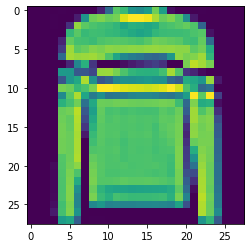

In [89]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [90]:
classes =train_dataset.classes

In [91]:
print(type(classes))
classes

<class 'list'>


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [92]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels =1, out_channels = 32,
                               kernel_size = 4,stride = 1,padding = 4,padding_mode ='zeros')
        
        self.pool = nn.MaxPool2d(kernel_size = 6, stride =2)
        
        self.conv2 = nn.Conv2d(in_channels =32, out_channels = 64,
                               kernel_size = 4,stride = 1,padding = 4,padding_mode ='zeros')
        
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim = 0)
        return x


# net = Net()
net = Net().to('cuda:0')

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [99]:
net.train()
epochs=20
for epoch in range(epochs):  
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.cuda(), labels.cuda()

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'эпоха: {epoch + 1} , итерация: {i}, loss:{loss}')

print('Training is finished!')

эпоха: 1 , итерация: 937, loss:2.030590057373047
эпоха: 2 , итерация: 937, loss:2.033539056777954
эпоха: 3 , итерация: 937, loss:2.0647432804107666
эпоха: 4 , итерация: 937, loss:2.074030637741089
эпоха: 5 , итерация: 937, loss:2.034303903579712
эпоха: 6 , итерация: 937, loss:2.033029794692993
эпоха: 7 , итерация: 937, loss:2.0346641540527344
эпоха: 8 , итерация: 937, loss:2.065670967102051
эпоха: 9 , итерация: 937, loss:2.065124273300171
эпоха: 10 , итерация: 937, loss:2.0439505577087402
эпоха: 11 , итерация: 937, loss:2.034409523010254
эпоха: 12 , итерация: 937, loss:2.030916929244995
эпоха: 13 , итерация: 937, loss:2.0336761474609375
эпоха: 14 , итерация: 937, loss:2.094564437866211
эпоха: 15 , итерация: 937, loss:2.062500476837158
эпоха: 16 , итерация: 937, loss:2.033609390258789
эпоха: 17 , итерация: 937, loss:2.0323991775512695
эпоха: 18 , итерация: 937, loss:2.093494176864624
эпоха: 19 , итерация: 937, loss:2.0333211421966553
эпоха: 20 , итерация: 937, loss:2.0351152420043945
Tr

In [100]:
PATH = './fashion.pth'
torch.save(net.state_dict(), PATH)

In [101]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [102]:
test_iter = iter(test_loader)
images, labels = test_iter.next()

true
['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
predict
['Ankle boot', 'Pullover', 'Trouser', 'Trouser']


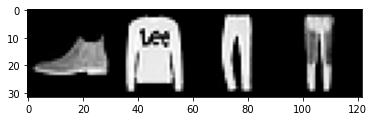

In [120]:
outputs = net(images)
_,predict = torch.max(outputs,axis=1)
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('true')
print([ classes[j] for j in labels])
print('predict')
print([ classes[j] for j in predict])

In [119]:
_,predict = torch.max(outputs,axis=1)

In [112]:
outputs

tensor([[3.9386e-09, 6.5447e-18, 5.8723e-21, 5.9646e-01, 9.9976e-01, 2.1022e-08,
         9.9823e-01, 9.9971e-01, 6.8140e-09, 1.0000e+00],
        [9.5675e-01, 1.9869e-09, 1.0000e+00, 4.0354e-01, 2.4410e-04, 9.9996e-01,
         1.8861e-11, 2.8032e-04, 7.3282e-01, 3.8384e-11],
        [3.6858e-02, 4.7885e-01, 1.6653e-14, 4.6738e-11, 6.7220e-08, 2.5768e-05,
         5.3692e-04, 7.2645e-06, 3.3392e-02, 6.1368e-25],
        [6.3906e-03, 5.2115e-01, 8.4992e-13, 4.0827e-11, 3.2872e-09, 1.1156e-05,
         1.2340e-03, 1.9205e-06, 2.3379e-01, 2.7475e-25]],
       grad_fn=<SoftmaxBackward>)